In [1]:
from pathlib import Path
import numpy as np
import pandas as pd

pd.set_option("display.max_colwidth", 0)
pd.set_option("display.max_rows", 0)

import pickle
import sys
import os
import json

if ".." not in sys.path:
    sys.path.append("..")

from typing import Dict, Tuple, Sequence, List

import matplotlib.pyplot as plt

In [2]:
from pp5 import OUT_DIR

PVAL_THRESH = 1.0

PREC_OUT_DIR = OUT_DIR.joinpath("prec-collected")
RESULTS_TAG = "pointwise_cdist-t_2-n_1-k_1000-noss"
# RESULTS_TAG = "pointwise_cdist-tmp"
INTERMEDIATE_DIR = "_intermediate_"

DATASET_DIRS = (
    PREC_OUT_DIR.joinpath("20210707_134426-aida-ex_EC-src_EC"),
    #     PREC_OUT_DIR.joinpath("20210102_112030-aida-ex_EC-src_HS-r18"),
    #     PREC_OUT_DIR.joinpath("20210102_112750-aida-ex_EC-src_ALL-r18"),
    #     PREC_OUT_DIR.joinpath("20210505_131701-photon"),
)

### Dataset stats

In [3]:
from pp5.analysis import DSSP_TO_SS_TYPE

# Maps from dataset tag to a metadata dict
datasets_meta = {}

# Maps from dataset tag to the group_sizes dict from results meta.json
datasets_group_sizes: Dict[str, dict] = {}

# Maps from dataset tag to it's path
dataset_result_dirs: Dict[str, Path] = {}

for i, ds_dir in enumerate(DATASET_DIRS):
    # Load dataset metadata
    meta_path = ds_dir.joinpath("meta.json")
    with open(meta_path, "r") as f:
        ds_meta = json.load(f)
    for _col in ("steps", "async_timeout", "create_zip"):
        ds_meta.pop(_col)
    tag = ds_meta.pop("out_tag") or f"ds_{i:02d}"

    # Load results metadata
    results_meta_path = ds_dir.joinpath("results", RESULTS_TAG, "meta.json")
    with open(results_meta_path, "r") as f:
        results_meta = json.load(f)

    # Copy some stats over from the results meta
    for group, group_meta in results_meta["group_sizes"].items():
        ds_meta[f"n_{group}"] = group_meta["total"]
    for _col in ("codon_tuple_len", "min_group_size", "t2_n_max", "t2_permutations"):
        ds_meta[_col] = results_meta[_col]

    # Save all group sizes
    datasets_group_sizes[tag] = results_meta["group_sizes"]

    # Load data
    data_prec_path = ds_dir.joinpath("data-precs.csv")
    df_pointwise = pd.read_csv(
        data_prec_path,
        usecols=("pdb_id", "res_id", "unp_id", "unp_idx", "codon", "secondary"),
        dtype={"unp_idx": "Int64"},
        header=0,
        # Consolidate different SS types into the ones we support
        converters={"secondary": lambda ss: DSSP_TO_SS_TYPE.get(ss, "")},
    )

    # Save some stats
    ds_meta["n_PDB_structs"] = len(df_pointwise.pdb_id.unique())
    ds_meta["n_UNP_records"] = len(df_pointwise.unp_id.unique())

    dataset_result_dirs[tag] = ds_dir.joinpath("results", RESULTS_TAG, INTERMEDIATE_DIR)
    assert dataset_result_dirs[tag].is_dir()
    datasets_meta[tag] = ds_meta

    ############
    # break

/Users/aviv/miniconda3/envs/proteins/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
df_datasets_meta = pd.DataFrame(datasets_meta)
df_datasets_meta.to_csv(f"out/pointwise_dataset_stats.csv", float_format="%.3f")
df_datasets_meta

,ex_EC-src_EC
codon_tuple_len,2
dataset_size_mb,29.90
expr_sys,Escherichia Coli
hostname,aida
...,...
source_taxid,562
t2_n_max,1000
t2_permutations,1000
write_csv,False


In [5]:
len(df_pointwise.pdb_id.unique()), len(df_pointwise.unp_id.unique())

(1621, 581)

## Helper Functions

In [6]:
def load_results(
    dataset_result_dirs: Dict[str, Path], result_names: Sequence[str]
) -> Dict[str, Sequence[Dict]]:
    # maps dataset tag -> [results_dict1, results_dict2, ...]
    dataset_loaded_results: Dict[str, Sequence[Dict]] = {}

    for ds_tag, ds_dir in dataset_result_dirs.items():
        loaded_results = []

        for result_name in result_names:
            result_path = ds_dir.joinpath(result_name)
            assert result_path.is_file(), f"{ds_tag=} {result_name=}"

            with open(result_path, "rb") as f:
                p = pickle.load(f)
                # remove the length-1 array
                # p = {k: v[0] for k,v in p.items()}

            loaded_results.append(p)

        dataset_loaded_results[ds_tag] = loaded_results

    return dataset_loaded_results

In [7]:
import itertools as it

csv_float_fmt = "%.5f"


def results_to_df(
    results: Dict[Tuple, Dict],
    index_col_names: Sequence[str],
    sort_by: Sequence[str] = (),
    split_cols: Sequence[str] = (),
    split_cols_delim: str = "_",
    write_csv: str = None,
):
    index = [k for k, v in results.items() for _ in v]
    index = pd.MultiIndex.from_tuples(index, names=index_col_names)

    data = it.chain(*results.values())
    df = pd.DataFrame(data=data, index=index)

    # Sort: always sort by index colums, and then by additional sort columns
    df = df.sort_values(by=[*index_col_names, *sort_by])

    # Split columns based on delimiter
    for col in split_cols:
        split_cols = df[col].str.split(split_cols_delim, -1, expand=True)
        split_cols.columns = [f"{col}.{i+1}" for i in split_cols.columns]
        df = pd.concat([df, split_cols], axis=1)

    if write_csv:
        df.to_csv(write_csv, float_format=csv_float_fmt)

    return df

### Codon vs. Codon

In [8]:
CODON_DIHEDRAL_PVALS = "codon-dihedral-pvals.pkl"
CODON_DIHEDRAL_T2S = "codon-dihedral-t2s.pkl"

# maps dataset tag -> (pval results, t2 results)
dataset_codon_dists: Dict[str, Sequence[Dict]] = load_results(
    dataset_result_dirs, result_names=[CODON_DIHEDRAL_PVALS, CODON_DIHEDRAL_T2S]
)

In [9]:
from pp5.codons import aac_tuples, aac_tuple_pairs, aac_index_pairs, AAC_TUPLE_SEP

# Assuming all results have the same tuple length
tuple_len = ds_meta["codon_tuple_len"]


SYN_TUPLES_IDX = sorted(aac_index_pairs(k=tuple_len, synonymous=True, unique=True))
SYN_TUPLES_IDX = np.array(SYN_TUPLES_IDX)

AAC_TUPLES = [str.join(AAC_TUPLE_SEP, (a1, a2)) for (a1, a2) in aac_tuples(k=2)]

print(f"{len(SYN_TUPLES_IDX)=}, {len(AAC_TUPLES)=}")

len(SYN_TUPLES_IDX)=29473, len(AAC_TUPLES)=3721


In [10]:
results_cc = {}

for ds_tag, (ds_pvals, ds_t2s) in dataset_codon_dists.items():
    assert ds_pvals.keys() == ds_t2s.keys()

    for ss_type in ds_pvals.keys():
        ds_ss_pvals = ds_pvals[ss_type]
        ds_ss_t2 = ds_t2s[ss_type]

        ds_ss_subgroup_sizes = datasets_group_sizes[ds_tag][ss_type]["subgroups"]

        syn_codon_pvals = ds_ss_pvals[tuple(zip(*SYN_TUPLES_IDX))]
        syn_significant_idx_flat = syn_codon_pvals <= PVAL_THRESH
        syn_significant_idx = SYN_TUPLES_IDX[syn_significant_idx_flat]

        results_cc[(ds_tag, ss_type)] = [
            {
                "tuple1": AAC_TUPLES[aac1],
                "tuple2": AAC_TUPLES[aac2],
                "n1": ds_ss_subgroup_sizes[AAC_TUPLES[aac1]],
                "n2": ds_ss_subgroup_sizes[AAC_TUPLES[aac2]],
                "pval": ds_ss_pvals[aac1, aac2],
                "t2": ds_ss_t2[aac1, aac2],
            }
            for aac1, aac2 in syn_significant_idx
        ]

In [11]:
index_col_names = ["Dataset", "SS"]

df_pvals_cc = results_to_df(
    results_cc,
    index_col_names=index_col_names,
    sort_by=["pval"],
    write_csv=f"out/pointwise_pvals_cc-{PVAL_THRESH}.csv",
    split_cols=["tuple1", "tuple2"],
    split_cols_delim=AAC_TUPLE_SEP,
)

df_pvals_cc

tuple1       tuple2  n1   n2  pval         t2 tuple1.1  \
Dataset      SS                                                                 
ex_EC-src_EC ANY  A-GCA_S-TCC  A-GCC_S-AGC  14  115  0.0   27.027071  A-GCA     
             ANY  A-GCC_R-CGC  A-GCG_R-AGA  65  16   0.0   5.733239   A-GCC     
             ANY  A-GCC_R-CGT  A-GCG_R-AGA  56  16   0.0   8.411426   A-GCC     
             ANY  A-GCC_S-TCA  A-GCC_S-TCG  11  11   0.0   10.718183  A-GCC     
...                       ...          ...  ..  ..   ...        ...     ...     
             ANY  T-ACA_R-AGA  T-ACT_R-CGA  2   2    1.0   0.456679   T-ACA     
             ANY  T-ACG_T-ACC  T-ACG_T-ACG  27  15   1.0  -0.640692   T-ACG     
             ANY  T-ACT_P-CCA  T-ACT_P-CCC  3   4    1.0   0.247317   T-ACT     
             ANY  V-GTA_T-ACC  V-GTG_T-ACC  22  67   1.0  -0.469984   V-GTA     

                 tuple1.2 tuple2.1 tuple2.2  
Dataset      SS                              
ex_EC-src_EC ANY  S-TCC    A-GCC    S-AGC    
             ANY  R-CGC    A-GCG    R-AGA    
             ANY  R-CGT    A-GCG    R-AGA    
             ANY  S-TCA    A-GCC    S-TCG    
...                 ...      ...      ...    
             ANY  R-AGA    T-ACT    R-CGA    
             ANY  T-ACC    T-ACG    T-ACG    
             ANY  P-CCA    T-ACT    P-CCC    
             ANY  T-ACC    V-GTG    T-ACC    

[20767 rows x 10 columns]

### AA vs. AA

In [12]:
AA_DIHEDRAL_PVALS = "aa-dihedral-pvals.pkl"
AA_DIHEDRAL_T2S = "aa-dihedral-t2s.pkl"

# maps dataset tag -> (pval results, t2 results)
dataset_aa_dists: Dict[str, Sequence[Dict]] = load_results(
    dataset_result_dirs, result_names=[AA_DIHEDRAL_PVALS, AA_DIHEDRAL_T2S]
)

In [13]:
from pp5.codons import aac_tuples, aac_tuple_pairs, aac_index_pairs, AAC_TUPLE_SEP


AA_TUPLES = [str.join(AAC_TUPLE_SEP, (a1[0], a2[0])) for (a1, a2) in aac_tuples(k=2)]
AA_TUPLES = sorted(set(AA_TUPLES))
print(f"{len(AA_TUPLES)=}")

len(AA_TUPLES)=400


In [14]:
results_aa = {}

for ds_tag, (ds_pvals, ds_t2s) in dataset_aa_dists.items():
    assert ds_pvals.keys() == ds_t2s.keys()

    for ss_type in ds_pvals.keys():
        ds_ss_pvals = ds_pvals[ss_type]
        ds_ss_t2 = ds_t2s[ss_type]

        ds_ss_subgroup_sizes = datasets_group_sizes[ds_tag][ss_type]["subgroups"]

        # Temp hack: remove redundant entries because for some reason they were calcualted
        ds_ss_pvals[np.tril_indices_from(ds_ss_pvals, k=-1)] = np.nan

        # [(aa1, aa2), (aa3, aa4), ...]
        aa_significant_idx = list(
            zip(
                # where returns ((aa1, aa2, ...), (codon1, codon2, ...))
                *np.where(ds_ss_pvals <= PVAL_THRESH)
            )
        )

        results_aa[(ds_tag, ss_type)] = [
            {
                "tuple1": AA_TUPLES[aa1],
                "tuple2": AA_TUPLES[aa2],
                "n1": ds_ss_subgroup_sizes[AA_TUPLES[aa1]],
                "n2": ds_ss_subgroup_sizes[AA_TUPLES[aa2]],
                "pval": ds_ss_pvals[aa1, aa2],
                "t2": ds_ss_t2[aa1, aa2],
            }
            for aa1, aa2 in aa_significant_idx
        ]

        print(f"{ss_type}: {len(aa_significant_idx)=}")

ANY: len(aa_significant_idx)=79800


In [15]:
df_pvals_aa = results_to_df(
    results_aa,
    index_col_names=index_col_names,
    sort_by=["pval"],
    write_csv=f"out/pointwise_pvals_aa-{PVAL_THRESH}.csv",
    split_cols=["tuple1", "tuple2"],
    split_cols_delim=AAC_TUPLE_SEP,
)

df_pvals_aa

tuple1 tuple2    n1   n2  pval          t2 tuple1.1 tuple1.2  \
Dataset      SS                                                                 
ex_EC-src_EC ANY  A_A    A_F    1197  391  0.0   56.717167   A        A         
             ANY  A_A    A_G    1197  760  0.0   500.013977  A        A         
             ANY  A_A    A_H    1197  194  0.0   23.095268   A        A         
             ANY  A_A    A_I    1197  614  0.0   94.488945   A        A         
...               ...    ...     ...  ...  ...         ...  ..       ..         
             ANY  V_Y    W_T    206   78   1.0  -1.069316    V        Y         
             ANY  W_I    Y_S    65    163  1.0  -0.616917    W        I         
             ANY  Y_C    Y_F    31    135  1.0  -0.709924    Y        C         
             ANY  Y_C    Y_I    31    150  1.0  -0.446404    Y        C         

                 tuple2.1 tuple2.2  
Dataset      SS                     
ex_EC-src_EC ANY  A        F        
             ANY  A        G        
             ANY  A        H        
             ANY  A        I        
...              ..       ..        
             ANY  W        T        
             ANY  Y        S        
             ANY  Y        F        
             ANY  Y        I        

[79800 rows x 10 columns]

In [16]:
# Filter out G & P
filter_pattern = "[^GP]_[^GP]"
idx = pd.Series([True] * len(df_pvals_aa), index=df_pvals_aa.index)
print(sum(idx))
for col in ("tuple1", "tuple2"):
    idx &= df_pvals_aa[col].str.fullmatch(filter_pattern)
    print(sum(idx))

df_pvals_aa_filtered = df_pvals_aa[idx]
df_pvals_aa_filtered = df_pvals_aa_filtered.sort_values(by=[*index_col_names, "pval"])
df_pvals_aa_filtered.to_csv(
    f"out/pointwise_pvals_aa-{PVAL_THRESH}-filtered.csv", float_format=csv_float_fmt
)
df_pvals_aa_filtered

79800
63882
52326


tuple1 tuple2    n1    n2  pval         t2 tuple1.1 tuple1.2  \
Dataset      SS                                                                 
ex_EC-src_EC ANY  A_A    A_F    1197  391   0.0   56.717167  A        A         
             ANY  A_A    A_H    1197  194   0.0   23.095268  A        A         
             ANY  A_A    A_I    1197  614   0.0   94.488945  A        A         
             ANY  A_A    A_L    1197  1175  0.0   16.751602  A        A         
...               ...    ...     ...  ...   ...         ... ..       ..         
             ANY  V_Y    W_T    206   78    1.0  -1.069316   V        Y         
             ANY  W_I    Y_S    65    163   1.0  -0.616917   W        I         
             ANY  Y_C    Y_F    31    135   1.0  -0.709924   Y        C         
             ANY  Y_C    Y_I    31    150   1.0  -0.446404   Y        C         

                 tuple2.1 tuple2.2  
Dataset      SS                     
ex_EC-src_EC ANY  A        F        
             ANY  A        H        
             ANY  A        I        
             ANY  A        L        
...              ..       ..        
             ANY  W        T        
             ANY  Y        S        
             ANY  Y        F        
             ANY  Y        I        

[52326 rows x 10 columns]

### AA vs. Codon

In [17]:
AAC_DIHEDRAL_PVALS = "aac-dihedral-pvals.pkl"
AAC_DIHEDRAL_T2S = "aac-dihedral-t2s.pkl"

# maps dataset tag -> (pval results, t2 results)
dataset_aac_dists: Dict[str, Sequence[Dict]] = load_results(
    dataset_result_dirs, result_names=[AAC_DIHEDRAL_PVALS, AAC_DIHEDRAL_T2S]
)

In [18]:
def is_aat_aact_match(aat: str, aact: str):
    for aa, aac in zip(aat.split(AAC_TUPLE_SEP), aact.split(AAC_TUPLE_SEP)):
        if aa != aac[0]:
            return False
    return True


AA_AAC_TUPLES = sorted(
    set(
        (aa, codon)
        for aa in AA_TUPLES
        for codon in AAC_TUPLES
        if is_aat_aact_match(aa, codon)
    )
)

print(f"{len(AA_AAC_TUPLES)}")

3721


In [19]:
results_ac = {}

for ds_tag, (ds_pvals, ds_t2s) in dataset_aac_dists.items():
    assert ds_pvals.keys() == ds_t2s.keys()
    for ss_type in ds_pvals.keys():
        ds_ss_pvals = ds_pvals[ss_type]
        ds_ss_t2s = ds_t2s[ss_type]
        ds_ss_subgroup_sizes = datasets_group_sizes[ds_tag][ss_type]["subgroups"]

        # [(aa1, codon1), (aa2, codon2), ...]
        aac_significant_idx = list(
            zip(
                # where returns ((aa1, aa2, ...), (codon1, codon2, ...))
                *np.where(ds_ss_pvals <= PVAL_THRESH)
            )
        )

        results_ac[(ds_tag, ss_type)] = [
            {
                "tuple1": AA_TUPLES[aa],
                "tuple2": AAC_TUPLES[codon],
                "n1": ds_ss_subgroup_sizes[AA_TUPLES[aa]],
                "n2": ds_ss_subgroup_sizes[AAC_TUPLES[codon]],
                "pval": ds_ss_pvals[aa, codon],
                "t2": ds_ss_t2s[aa, codon],
            }
            for aa, codon in aac_significant_idx
        ]

In [20]:
df_pvals_ac = results_to_df(
    results_ac,
    index_col_names=index_col_names,
    sort_by=["pval"],
    write_csv=f"out/pointwise_pvals_ac-{PVAL_THRESH}.csv",
    split_cols=["tuple1", "tuple2"],
    split_cols_delim=AAC_TUPLE_SEP,
)

df_pvals_ac

tuple1       tuple2   n1  n2  pval          t2 tuple1.1  \
Dataset      SS                                                            
ex_EC-src_EC ANY  A_R    A-GCG_R-AGA  574  16  0.0   93.034698   A         
             ANY  F_P    F-TTT_P-CCA  79   15  0.0   34.545200   F         
             ANY  I_A    I-ATT_A-GCG  705  75  0.0   10.958311   I         
             ANY  I_R    I-ATT_R-CGG  317  14  0.0   142.511322  I         
...               ...            ...  ...  ..  ...         ...  ..         
             ANY  A_N    A-GCC_N-AAC  372  66  1.0  -0.422817    A         
             ANY  G_R    G-GGA_R-CGG  294  7   1.0  -0.802722    G         
             ANY  G_R    G-GGC_R-CGA  294  5   1.0  -0.566785    G         
             ANY  L_R    L-TTG_R-CGT  562  55  1.0  -0.489257    L         

                 tuple1.2 tuple2.1 tuple2.2  
Dataset      SS                              
ex_EC-src_EC ANY  R        A-GCG    R-AGA    
             ANY  P        F-TTT    P-CCA    
             ANY  A        I-ATT    A-GCG    
             ANY  R        I-ATT    R-CGG    
...              ..          ...      ...    
             ANY  N        A-GCC    N-AAC    
             ANY  R        G-GGA    R-CGG    
             ANY  R        G-GGC    R-CGA    
             ANY  R        L-TTG    R-CGT    

[3445 rows x 10 columns]

## Figures

In [34]:
def mht_bh(q: float, pvals: np.ndarray, plot=False):
    """
    Multiple hypothesis testing with BH(q) method.
    :param q: The desired maximal FDR level (holds only in expectation accross
        multiple realizations of the problem).
    :param pvals: 1d array of p-values corresponding to m different null hypotheses.
    :return: The threshold to use for determining which of the null hypotheses to
        reject (reject where pvals < mht_bh(q, pvals)).
    """
    m = len(pvals)

    # Sort the pvals from low to high
    idx_sorted = pvals.argsort()
    pvals_sorted = pvals[idx_sorted]

    # Calcualte a different threshold for each pval based on it's rank
    bhq_thresh = (np.arange(m) + 1) * (q / m)

    # Find the index of the largest pval that's below its assigned threshold
    i0 = m - 1 - np.argmax([*reversed(pvals_sorted <= bhq_thresh)])

    # Sanity check
    assert pvals_sorted[i0] <= bhq_thresh[i0]
    if i0 + 1 < m:
        assert pvals_sorted[i0 + 1] > bhq_thresh[i0]

    if plot:
        fig, ax = plt.subplots(figsize=(10, 7))
        ax.plot(np.arange(m), bhq_thresh, label="BH(q) thresh")
        ax.scatter(
            np.arange(m)[:i0], pvals_sorted[:i0], color="red", label="rejected nulls"
        )
        ax.scatter(
            np.arange(m)[i0:],
            pvals_sorted[i0:],
            color="blue",
            label="non-rejected nulls",
        )
        ymin, ymax = ax.get_ylim()
        ax.vlines(
            i0,
            ymin,
            ymax,
            linewidths=2,
            linestyles="dashed",
            colors="black",
            label=f"{i0=}",
        )
        ax.legend()

    # Return the corresponding threshold of that pval
    # This threshold should be used to determine significance among the
    # given hypotheses.
    return bhq_thresh[i0]

0.06749749373433583

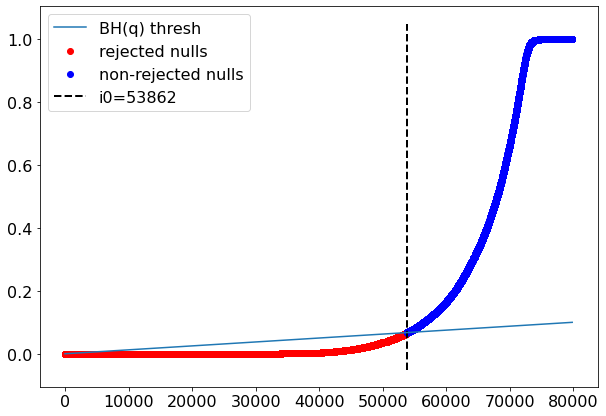

In [35]:
mht_bh(q=0.1, pvals=df_pvals_aa["pval"], plot=True)

name='C-C', m=20767, %rejected=0.39
name='A-A', m=79800, %rejected=67.50
name='A-C', m=3445, %rejected=0.32


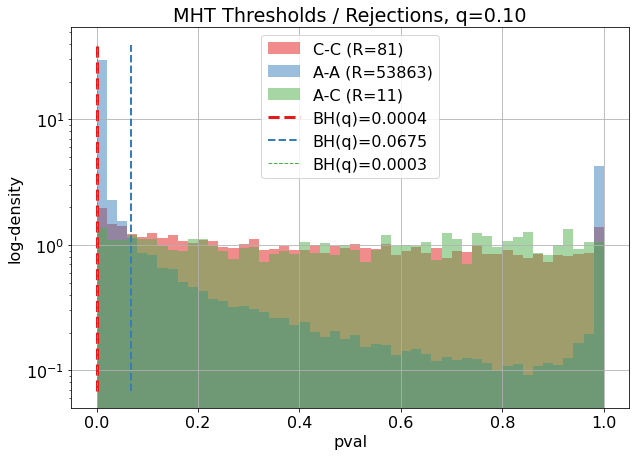

In [36]:
plt.rcParams["font.size"] = 16

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
colors = plt.cm.Set1.colors

nbins = 50
q = 0.1

zip_name_df = tuple(zip(["C-C", "A-A", "A-C"], [df_pvals_cc, df_pvals_aa, df_pvals_ac]))

for i, (name, df) in enumerate(zip_name_df):
    thresh = mht_bh(q, df["pval"])
    num_rejections = np.sum(df["pval"] < thresh)
    df.hist(
        "pval",
        bins=nbins,
        ax=ax,
        density=True,
        log=True,
        color=colors[i],
        alpha=0.5,
        label=f"{name} (R={num_rejections})",
    )
    m = len(df["pval"])
    print(f"{name=}, {m=}, %rejected={num_rejections/m*100:.2f}")


ymin, ymax = ax.get_ylim()
for i, (name, df) in enumerate(zip_name_df):
    thresh = mht_bh(q, df["pval"])
    ax.vlines(
        thresh,
        ymin,
        ymax,
        linewidths=1 * (len(zip_name_df) - i),
        linestyles="dashed",
        colors=colors[i],
        label=f"BH(q)={thresh:.04f}",
    )

ax.set_title(f"MHT Thresholds / Rejections, {q=:.2f}")
ax.set_ylabel("log-density")
ax.set_xlabel("pval")
ax.legend()
fig.savefig("out/pointwise_pvals_hist.png", bbox_inches="tight", dpi=150)